In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [3]:
print(tf.__version__)

2.12.0


In [4]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /private/var/folders/vv/4xgdn8lj2_z_rfrfl1cqw3100000gp/T/pip-req-build-1nsgh5ev
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/vv/4xgdn8lj2_z_rfrfl1cqw3100000gp/T/pip-req-build-1nsgh5ev
  Resolved https://github.com/tensorflow/docs to commit 84bd7bea0c468667dd0ec273d426ed50f23e1a15
  Preparing metadata (setup.py) ... done


In [5]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [2]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [3]:
logdir = pathlib.Path(tempfile.mktemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
log_dir

NameError: name 'log_dir' is not defined

# 힉스(Higgs) 데이터세트

- 각각 28개의 특성과 이진 클래스 레이블이 있는 11,000,000개의 예제 포함

In [8]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [9]:
FEATURES = 28

- `tf.data.experimental.CsvDataset` : 중간 압축 해제 단계 없이 gzip 파일에서 직접 csv 레코드를 읽는 데 사용
- 해당 csv 판독기 클래스는 각 레코드에 대한 스칼라 목록을 반환
- 다음 함수는 해당 스칼라 목록을 (feature_vector, label) 쌍으로 다시 압축

In [10]:
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type='GZIP')

- 각 행을 개별적으로 다시 압축하는 대신 10,000개 예제의 배치를 취하고 각 배치에 pack_row 함수를 적용한 다음 배치를 다시 개별 레코드로 분할하는 새로운 `tf.data.Dataset` 생성

In [11]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

In [12]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


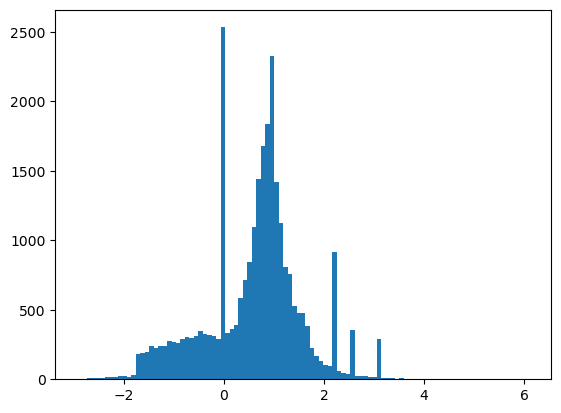

In [13]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [25]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [26]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [27]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [28]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

# 과대적합 예제

- 과적합을 방지하는 가장 간단한 방법은 작은 모델, 즉 학습 가능한 매개변수 수가 적은 모델(레이어 수와 레이어당 단위 수에 의해 결정됨)로 시작하는 것입니다. 
- 딥 러닝에서 모델의 학습 가능한 매개변수 수를 종종 모델의 "용량"이라고 합니다.
- 직관적으로 생각할 때 더 많은 매개변수를 가진 모델이 더 많은 "기억 용량"을 가지므로 훈련 샘플과 대상 간에 완벽한 사전과 같은 매핑, 일반화 능력이 없는 매핑을 쉽게 학습할 수 있지만 이전에 보지 못한 데이터에서 예측할 때는 이것이 쓸모가 없습니다.
- 항상 명심할 점! 딥 러닝 모델은 훈련 데이터에 피팅이 잘 되는 경향이 있지만 실제 문제는 피팅이 아닌 일반화입니다.
- 반면에 네트워크에 기억 리소스가 제한되어 있으면 매핑을 쉽게 학습할 수 없습니다. 손실을 최소화하려면 예측력이 더 높은 압축된 표현을 학습해야 합니다. 동시에 모델을 너무 작게 만들면 훈련 데이터에 피팅하기가 어렵습니다. "용량이 너무 많음"과 "용량이 충분하지 않음" 사이에 균형이 존재합니다.
- 불행히도 모델의 올바른 크기나 아키텍처(레이어 수 또는 각 레이어의 올바른 크기 측면에서)를 결정하는 마법과 같은 공식은 없습니다. 일련의 다른 아키텍처를 사용하여 실험해 보아야 합니다.
- 적절한 모델 크기를 찾으려면 비교적 적은 수의 레이어와 매개변수로 시작한 다음 유효성 검사 손실에 대한 이득 감소가 나타날 때까지 레이어의 크기를 늘리거나 새 레이어를 추가하는 것이 가장 좋습니다.

## 기준 모델 만들기

In [29]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

In [30]:
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

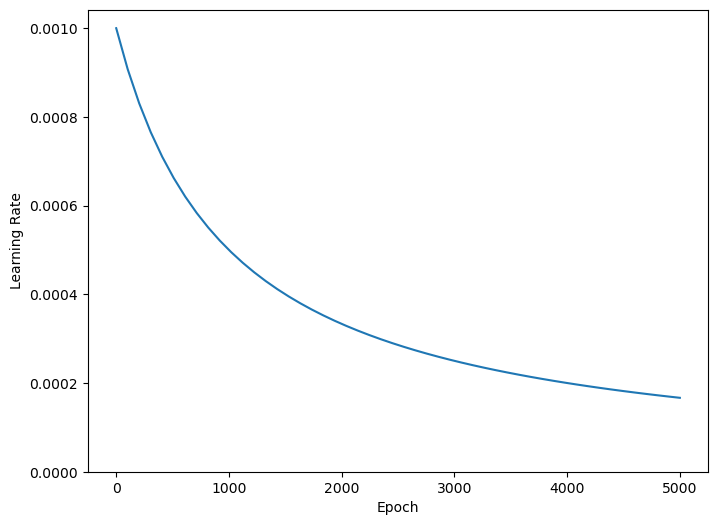

In [31]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [32]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

In [33]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
        
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                      tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'), 'accuracy'])
    model.summary()
    
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0)
    
    return history

## 미소 모델

In [34]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [35]:
size_histories = {}

In [36]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4738,  binary_crossentropy:0.7710,  loss:0.7710,  val_accuracy:0.4860,  val_binary_crossentropy:0.7310,  val_loss:0.7310,  
....................................................................................................
Epoch: 100, accuracy:0.5955,  binary_crossentropy:0.6268,  loss:0.6268,  val_accuracy:0.5750,  val_binary_crossentropy:0.6270,  val_loss:0.6270,  
..........................................................

(0.5, 0.7)

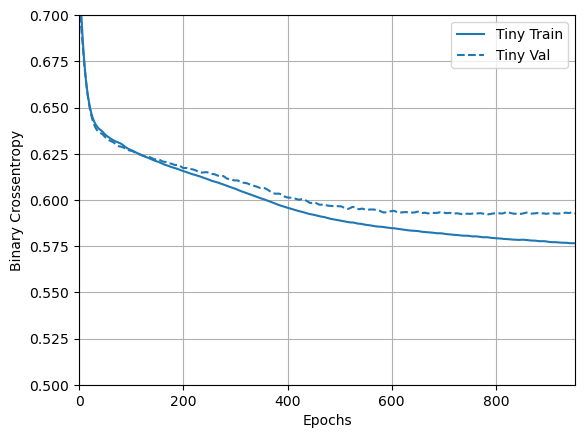

In [39]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

## 작은 모델

In [40]:
small_model = tf.keras.Sequential([
    # input_shape is only required here so that .summary works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [41]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                464       
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4734,  binary_crossentropy:0.8424,  loss:0.8424,  val_accuracy:0.4850,  val_binary_crossentropy:0.7402,  val_loss:0.7402,  
....................................................................................................
Epoch: 100, accuracy:0.6369,  binary_crossentropy:0.6047,  loss:0.6047,  

## 작은 모델 만들기

In [42]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [43]:
size_histories['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                1856      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4935,  binary_crossentropy:0.6961,  loss:0.6961,  val_accuracy:0.4890,  val_binary_crossentropy:0.6739,  val_loss:0.6739,  
....................................

## 큰 모델 만들기

In [44]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [45]:
size_histories['Large'] = compile_and_fit(large_model, 'sizes/Large')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 512)               14848     
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                                 
 dense_15 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5191,  binary_crossentropy

## 훈련 손실과 검증 손실 그래프 그리기

- 실선은 훈련 손실을 나타내고 점선은 유효성 검사 손실을 나타냅니다(기억할 점: 유효성 검사 손실이 낮을수록 더 나은 모델을 나타냄).
- 더 큰 모델을 빌드하면 더 많은 파워가 제공되지만 이 파워가 어떤 이유로 제한되지 않으면 훈련 세트에 쉽게 과대적합될 수 있습니다.
- 이 예에서는 일반적으로 "Tiny" 모델만 과대적합을 완전히 피하고 더 큰 각 모델은 데이터를 더 빠르게 과대적합합니다. "Large" 모델의 경우 이것이 너무 심각해져서 실제로 어떤 상황이 발생하는지 파악하려면 플롯을 로그 스케일로 전환해야 합니다.
- 검증 메트릭을 플롯하고 이를 훈련 메트릭과 비교하면 이것이 분명해집니다.
    1. 약간의 차이가 있는 것이 정상입니다.
    2. 두 메트릭이 같은 방향으로 움직이면 모든 것이 정상입니다.
    3. 훈련 메트릭이 계속 개선되는 동안 검증 메트릭이 정체되기 시작하면 과대적합에 가까워진 것입니다.
    4. 검증 메트릭이 잘못된 방향으로 가고 있다면 모델이 확실하게 과대적합된 것입니다.

Text(0.5, 0, 'Epochs [Log Scale]')

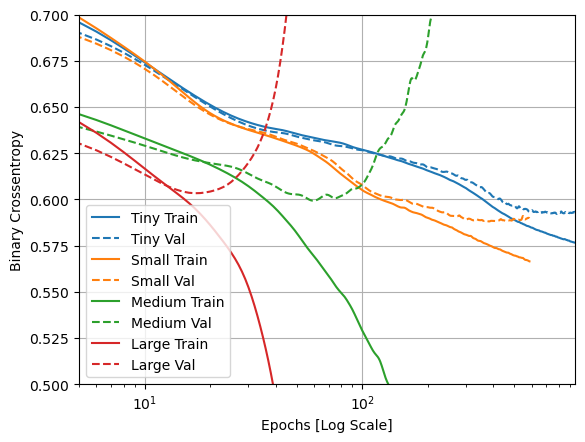

In [46]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

## TensorBoard에서 보기

In [47]:
%load_ext tensorboard

In [48]:
%tensorboard --logdir {logdir}/sizes

In [49]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [50]:
# tensorboard dev upload --logdir  {logdir}/sizes

# 과대적합을 방지하기 위한 전략

In [51]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/var/folders/vv/4xgdn8lj2_z_rfrfl1cqw3100000gp/T/tmp29ylejot/tensorboard_logs/regularizers/Tiny')

In [52]:
regularizer_histories = {}

In [53]:
regularizer_histories['Tiny'] = size_histories['Tiny']

## 가중치를 규제하기

- 아마도 오캄의 면도날(Occam's Razor) 이론을 들어 보았을 것입니다. 어떤 것을 설명하는 두 가지 방법이 있다면 더 정확한 설명은 최소한의 가정이 필요한 가장 "간단한" 설명일 것입니다. 이는 신경망으로 학습되는 모델에도 적용됩니다. 훈련 데이터와 네트워크 구조가 주어졌을 때 이 데이터를 설명할 수 있는 가중치의 조합(즉, 가능한 모델)은 많습니다. 간단한 모델은 복잡한 것보다 과대적합되는 경향이 작을 것입니다.
- 여기에서 "간단한 모델"은 매개변수 값의 분포가 엔트로피가 적은 모델(또는 위의 섹션에서 설명한 것처럼 매개변수가 모두 거의 없는 모델)입니다. 따라서 과대적합을 완화하는 일반적인 방법은 가중치가 작은 값만 사용하도록 하여 가중치 값의 분포를 보다 "정규화"하여 네트워크의 복잡성에 제약을 가하는 것입니다. 이것을 "가중치 정규화"라고 하며, 큰 가중치를 갖는 것과 관련된 비용을 네트워크의 손실 함수에 추가하는 방식으로 수행됩니다. 이 비용은 다음과 같이 두 가지 형태로 제공됩니다.
- L1 규제는 가중치의 절댓값에 비례하는 비용이 추가됩니다(즉, 가중치의 "L1 노름(norm)"을 추가합니다).
- L2 규제는 가중치의 제곱에 비례하는 비용이 추가됩니다(즉, 가중치의 "L2 노름"의 제곱을 추가합니다). 신경망에서는 L2 규제를 가중치 감쇠(weight decay)라고도 부릅니다. 이름이 다르지만 혼돈하지 마세요. 가중치 감쇠는 수학적으로 L2 규제와 동일합니다.
- L1 정규화는 가중치를 정확히 0으로 푸시하여 희소 모델을 유도합니다. L2 정규화는 가중치 매개변수를 희소하게 만들지 않고 여기에 페널티를 부여하는데 이는 작은 가중치에 대해서는 페널티가 0이 되기 때문입니다(L2가 더 일반적인 이유 중 하나).
- l2(0.001)는 네트워크의 전체 손실에 층에 있는 가중치 행렬의 모든 값이 0.001 * weight_coefficient_value**2만큼 더해진다는 의미입니다. 이런 페널티(penalty)는 훈련할 때만 추가됩니다. 따라서 테스트 단계보다 훈련 단계에서 네트워크 손실이 훨씬 더 클 것입니다.
- 이것이 바로 우리가 binary_crossentropy를 직접 모니터링하는 이유입니다. 이 정규화 구성 요소가 혼합되어 있지 않기 때문입니다.
- 따라서 L2 정규화 패널티가 있는 이 동일한 "Large" 모델의 성능이 훨씬 더 좋습니다.

In [54]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES, )),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

In [55]:
regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               14848     
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 dense_20 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5016,  binary_crossentropy

(0.5, 0.7)

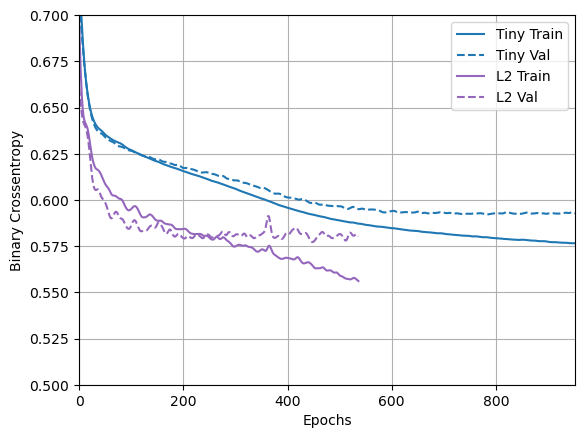

In [56]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

다음과 같이 이러한 종류의 정규화에 대해 주목해야 할 두 가지 중요한 사항이 있습니다.
- 자체 훈련 루프를 작성하는 경우 모델에 정규화 손실을 요청해야 합니다.
```
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)
```
- 이 구현은 모델의 손실에 가중치 패널티를 추가한 다음 표준 최적화 절차를 적용하는 식으로 작동합니다.
    - 대신에 원시 손실에 대해서만 옵티마이저를 실행한 다음 계산된 단계를 적용하는 동안 옵티마이저가 약간의 가중치 감소를 적용하는 두 번째 접근 방식이 있습니다. 
    - 이 "분리된 가중치 감소"는 `tf.keras.optimizers.Ftrl` 및 `tfa.optimizers.AdamW`와 같은 옵티마이저에서 사용됩니다.

## 드롭아웃 추가하기

- 드롭아웃은 신경망에 대해 가장 효과적이고 가장 일반적으로 사용되는 정규화 기술 중 하나로, 토론토 대학에서 Hinton과 그의 학생들이 개발했습니다.
- 드롭아웃을 직관적으로 설명하면, 네트워크의 개별 노드가 다른 노드의 출력에 의존할 수 없기 때문에 각 노드는 자체적으로 유용한 요소를 출력해야 한다는 것입니다.
- 레이어에 적용되는 드롭아웃은 훈련 중에 레이어의 여러 출력 요소를 무작위로 "드롭아웃"(즉, 0으로 설정)하는 식으로 작동합니다. 예를 들어 보통의 경우 주어진 레이어는 훈련 중 주어진 입력 샘플에 대해 벡터 [0.2, 0.5, 1.3, 0.8, 1.1]을 반환할 수 있습니다. 드롭아웃을 적용한 후 이 벡터에는 무작위로 분포된 몇 개의 0 항목이 있습니다(예: [0, 0.5, 1.3, 0, 1.1]).
- "드롭아웃 비율"은 0이 되는 특성의 비율로, 일반적으로 0.2에서 0.5 사이로 설정됩니다. 테스트 시간에는 어떤 유닛도 드롭아웃되지 않고 대신 레이어의 출력 값이 드롭아웃 비율과 동일한 계수만큼 축소되는데, 이는 훈련 시간에 더 많은 유닛이 활성화된다는 사실과 균형을 맞추기 위해서입니다.
- Keras에서 tf.keras.layers.Dropout 레이어를 통해 네트워크에 드롭아웃을 도입할 수 있습니다. 이 레이어는 직전 레이어의 출력에 적용됩니다.

In [57]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES, )),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [58]:
regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 512)              

(0.5, 0.7)

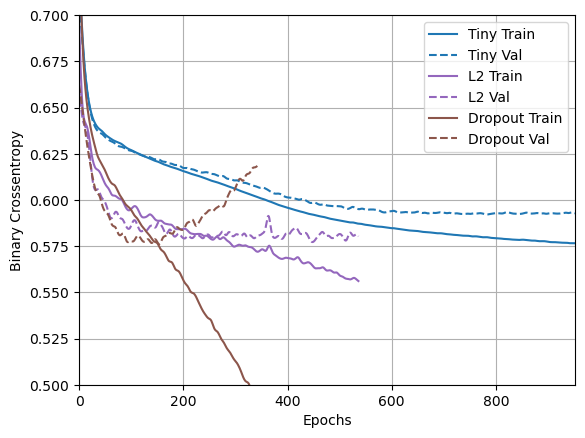

In [59]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

## L2 + 드롭아웃 결합

In [60]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES, )),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [61]:
regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 512)              

(0.5, 0.7)

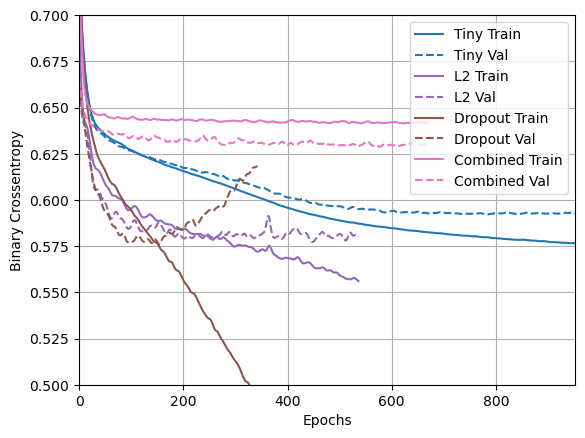

In [62]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

## TensorBoard에서 보기

In [65]:
%reload_ext tensorboard

In [67]:
%tensorboard --logdir {logdir}/regularizers

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

E0415 23:09:32.136668 140704431522624 application.py:125] Failed to load plugin WhatIfToolPluginLoader.load; ignoring it.
Traceback (most recent call last):
  File "/Users/rainmaker/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/tensorboard/backend/application.py", line 123, in TensorBoardWSGIApp
    plugin = loader.load(context)
  File "/Users/rainmaker/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/tensorboard_plugin_wit/wit_plugin_loader.py", line 57, in load
    from tensorboard_plugin_wit.wit_plugin import WhatIfToolPlugin
  File "/Users/rainmaker/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/tensorboard_plugin_wit/wit_plugin.py", line 40, in <module>
    from

In [68]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

# 결론

요약하자면 신경망에서 과대적합을 방지하는 가장 일반적인 방법은 다음과 같습니다. 각 방법은 그 자체로 도움이 될 수 있지만 이를 결합하여 더 큰 효과를 거둘 수 있는 경우가 종종 있다는 점을 기억하기 바랍니다.

1. 더 많은 훈련 데이터를 얻음
2. 네트워크 용량을 줄임
3. 가중치 정규화를 추가함
4. 드롭아웃을 추가함
5. 이 가이드에서 다루지 않는 두 가지 중요한 접근 방식은 다음과 같습니다.
    - 데이터 증강
    - 배치 정규화(tf.keras.layers.BatchNormalization)